In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib as ta
import datetime

In [51]:
df = yf.download('SBIN.NS', '2021-07-06', '2021-07-13', interval = '5m')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-07-06 09:15:00+05:30,431.700012,433.500000,431.450012,432.950012,432.950012,0
2021-07-06 09:20:00+05:30,433.149994,433.149994,431.850006,432.000000,432.000000,611971
2021-07-06 09:25:00+05:30,432.100006,432.200012,431.299988,431.350006,431.350006,311707
2021-07-06 09:30:00+05:30,431.350006,432.649994,431.299988,432.100006,432.100006,326986
2021-07-06 09:35:00+05:30,432.100006,432.200012,431.850006,432.000000,432.000000,142204
...,...,...,...,...,...,...
2021-07-12 15:05:00+05:30,427.700012,427.750000,427.049988,427.250000,427.250000,164788
2021-07-12 15:10:00+05:30,427.250000,427.450012,427.149994,427.399994,427.399994,163559
2021-07-12 15:15:00+05:30,427.399994,427.500000,427.200012,427.399994,427.399994,265200


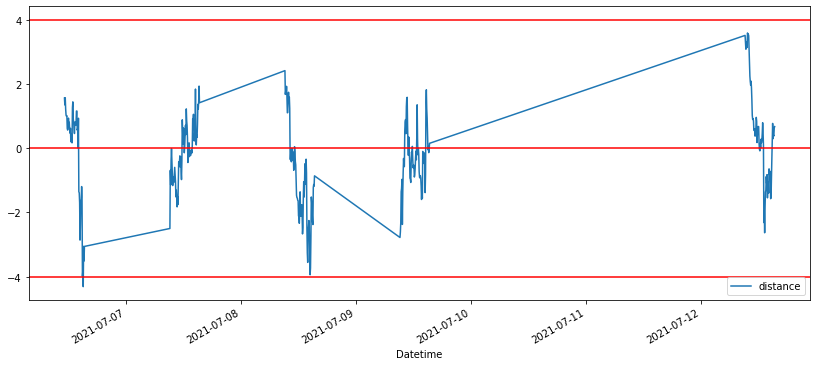

In [52]:
df['returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
EMA = 25
df['EMA'] = ta.EMA(df['Adj Close'], timeperiod = 25)
threshold = 4
df['distance'] = df['Adj Close'] - df['EMA']
df['distance'].dropna().plot(figsize=(14,6), legend= True)
plt.axhline(threshold, color= 'r')
plt.axhline(-threshold, color= 'r')
plt.axhline(0, color= 'r')

<AxesSubplot:xlabel='Datetime'>

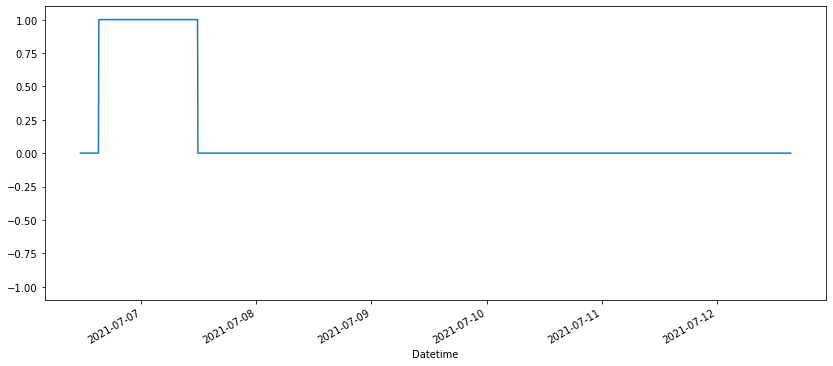

In [53]:
df['position'] = np.where(df['distance'] > threshold, -1, np.NaN)
df['position'] = np.where(df['distance'] < -threshold, 1, df['position'])
df['position'] = np.where(df['distance']* df['distance'].shift(1) < 0, 0, df['position'])
df['position'] = df['position'].ffill().fillna(0)
df['position'].iloc[EMA:].plot(ylim=[-1.1, 1.1], figsize=(14,6))

<AxesSubplot:xlabel='Datetime'>

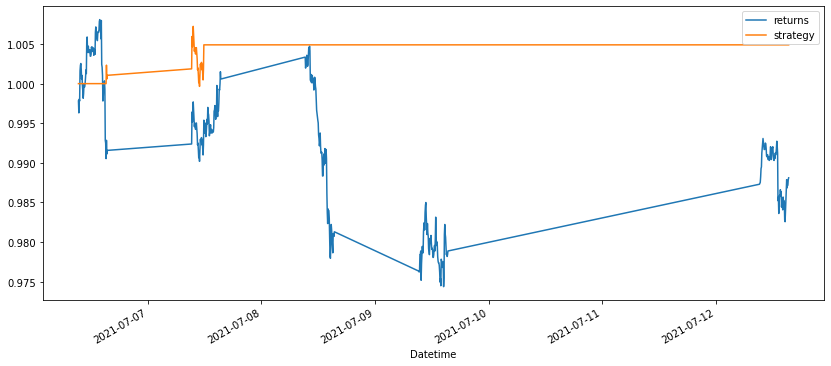

In [54]:
df['strategy'] = df['position'].shift(1)*df['returns']
df[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(14,6))

In [48]:
class MomVectorBacktester(object):
    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()
        
    def get_data(self):
        df = yf.download(f'{self.symbol}.NS', self.start, self.end)
        df['returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
        self.data = df
    
    def run_strategy(self, momentum=1):
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['returns'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1)*data['returns']
        #determine when a trade takes place
        trades = data['position'].diff().fillna(0) != 0
        #substract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount*data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount *data['strategy'].cumsum().apply(np.exp)
        self.results = data
        #absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        #out performace of the strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf,2), round(operf,2)
    
    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(14,6))

In [49]:
class MRVectorBacktester(MomVectorBacktester):
    def run_strategy(self, EMA, threshold):
        data = self.data.copy().dropna()
        data['EMA'] = ta.EMA(data['Adj Close'], timeperiod=EMA)
        data['distance'] = data['Adj Close'] - data['EMA']
        data.dropna(inplace = True)
        #sell signals
        data['position'] = np.where(data['distance'] > threshold, -1, np.nan)
        #buy signals
        data['position'] = np.where(data['distance'] < threshold, 1, data['position'])
        #crossing of current price and EMA(zero distance)
        data['position'] = np.where(data['distance']*data['distance'].shift(1) < 0, 0, data['position'])
        data['position'] = data['position'].ffill().fillna(0)
        data['strategy'] = data['position'].shift(1)*data['returns']
        #determine when a trade take place
        trades = data['position'].diff().fillna(0) != 0
        #substract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount* data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount* data['strategy'].cumsum().apply(np.exp)
        self.results = data
        #absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        #out performance of the strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf,2)
        

[*********************100%***********************]  1 of 1 completed


<ipython-input-49-3e42343d77a1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy'][trades] -= self.tc


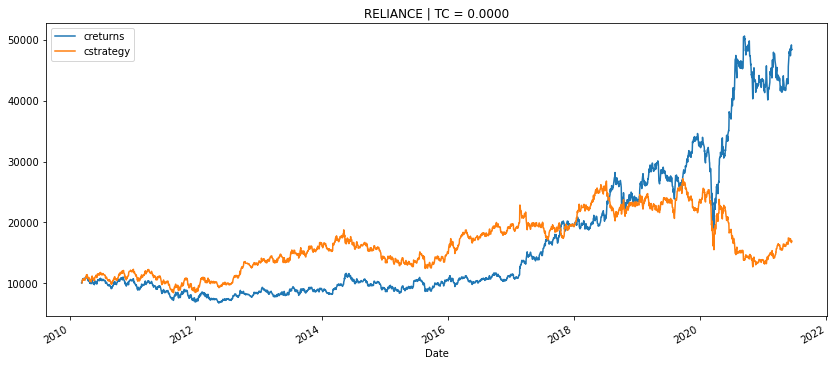

In [50]:
mrbt = MRVectorBacktester('RELIANCE', '2010-01-01', '2021-06-18', 10000, 0.0)
mrbt.run_strategy(EMA=46, threshold=25)
mrbt.plot_results()